In [1]:
import argparse
import glob
import os
import pathlib
import _pickle

import autograd.numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

import phlearn.phsystems as phsys
import phlearn.phnns as phnn

from scipy.integrate import solve_ivp
from scipy.sparse import diags

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
ttype = torch.float32
torch.set_default_dtype(ttype)
%matplotlib notebook
custom_colors = sns.color_palette([(1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0.6,0.8,.8), (0,0.4,1), (0.5,0.3,.5)])
sns.set_palette(custom_colors)

plot_settings = {
    'axes.prop_cycle': mpl.cycler(color=custom_colors),
    'text.usetex': True,
    'font.family': 'serif',
    'axes.titlesize': 9,
    'figure.titlesize': 9,
    'legend.title_fontsize': 8,
    'axes.labelsize': 9,
    'font.size': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'savefig.dpi': 300,
}


plt.rcParams.update(plot_settings)

In [2]:
modelfolder = 'trained_models_kdv/'
df = pd.DataFrame(columns=['system_type', 'baseline', 'ntrainingpoints', 'sampling_time', 't_max',
                           'F_timedependent', 'F_spacedependent', 'F_statedependent', 'pHnn_model', 'val_loss'])
for f in glob.glob(modelfolder+"/*"):
    if ('DS_store' not in f) and ('.csv' not in f):
        model, optimizer, metadict = phnn.load_dynamic_system_model(f)
        #print('metadict[traininginfo]:', metadict['traininginfo'].keys())
        df.loc[f[19:]] = {'system_type': metadict['traininginfo']['system'],
                                   'baseline': int(metadict['traininginfo']['baseline']),
                                   'ntrainingpoints': metadict['traininginfo']['ntrainingpoints'],
                                   'sampling_time': metadict['traininginfo']['sampling_time'],
                                   't_max': metadict['traininginfo']['t_max'],
                                   'F_timedependent': bool(metadict['traininginfo']['F_timedependent']),
                                   'F_spacedependent': bool(metadict['traininginfo']['F_spacedependent']),
                                   'F_statedependent': bool(metadict['traininginfo']['F_statedependent']),
                                   'val_loss': metadict['traininginfo']['val_loss'],
                                   'pHnn_model': model}

In [3]:
dt_rollout = 0.01
extrapolate = False
t_max = 1
dt = 0.02
result_file = f'testresults_dt{dt_rollout:.0e}_n10_t{int(t_max)}.csv'
t_max = 1
stored_results_path = os.path.join(modelfolder, result_file)
stored_df = pd.read_csv(stored_results_path, index_col=0)

df.loc[stored_df.index, stored_df.columns] = stored_df.loc[stored_df.index, :].values.copy()

In [4]:
df = df[df['sampling_time'] == dt]
df['MSE'] = df['MSE']
df['Model type'] = df['baseline'].astype(int)
df['Model type'] = df['Model type'].map({1:'Baseline (1NN)', 2:'Baseline (2NN)',
                                         3:'PHNN (general)', 0:'PHNN (informed)'})
type_order = ['1N baseline', '2N baseline', 'PHNN (general)', 'PHNN (informed)']

In [5]:
df

,system_type,baseline,ntrainingpoints,sampling_time,t_max,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime,Model type
20230410170452004485.model,kdv,0,20,0.02,0.02,False,True,False,ConservativeDissipativeNN(\n (external_forces...,None,3.358571,13.455238,PHNN (informed)
20230410163758051544.model,kdv,1,20,0.02,0.02,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,None,4.038062,7.907228,Baseline (1NN)
20230410170244790025.model,kdv,0,20,0.02,0.02,False,True,False,ConservativeDissipativeNN(\n (external_forces...,None,280.150127,785.656653,PHNN (informed)
20230410164332595922.model,kdv,2,20,0.02,0.02,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineSp...,None,4.074487,14.369757,Baseline (2NN)
20230410172101030829.model,kdv,3,20,0.02,0.02,False,True,False,ConservativeDissipativeNN(\n (external_forces...,None,0.044293,0.097905,PHNN (general)
20230410164007826040.model,kdv,1,20,0.02,0.02,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,None,10.391378,38.258016,Baseline (1NN)
20230410172010848167.model,kdv,3,20,0.02,0.02,False,True,False,ConservativeDissipativeNN(\n (external_forces...,None,7.101736,30.460543,PHNN (general)
20230410164345245269.model,kdv,2,20,0.02,0.02,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineSp...,None,0.245299,0.605381,Baseline (2NN)
20230410170200498301.model,kdv,0,20,0.02,0.02,False,True,False,ConservativeDissipativeNN(\n (external_forces...,None,205.912271,512.204409,PHNN (informed)
20230410163921744477.model,kdv,1,20,0.02,0.02,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,None,39.229552,130.391634,Baseline (1NN)


In [6]:
x_max = 20
x_points = 100
dx = x_max/x_points
x = np.linspace(0,x_max-dx,x_points)
eta = 6.
gamma = 1.
nu = 0.3 # coefficient of viscosity term
# def F(u, t):
#     return 0
def F(u, t):
    return 1*.6*np.sin(2*2*np.pi/x_max*x)
def JF(u,t):
    return np.zeros((u.shape[0],u.shape[0]))
PDE_system = phsys.KdVSystem(x=x, eta=eta, gamma=gamma, nu=nu, force=F, force_jac=JF, init_sampler=phsys.initial_condition_kdv(x, eta))

<IPython.core.display.Javascript object>


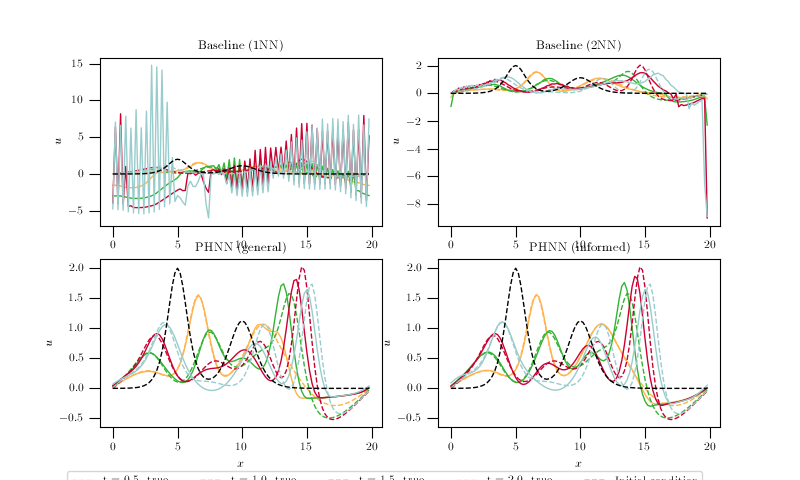

In [7]:
t_max = 2
k1, k2 = 1., .75
d1, d2 = .25, .5
eta = 6.
P = (x[-1]-x[0])*x.size/(x.size-1)
u0 = (-6./-eta)*2*k1**2 * 1/np.cosh(k1*(x-P*d1))**2
u0 += (-6./-eta)*2*k2**2 * 1/np.cosh(k2*(x-P*d2))**2

bestmodels = []
for modeltype, grp in df.groupby('Model type'):
    bestmodelstats = grp.sort_values('MSE').iloc[0]
    bestmodel, _, bestmodel_metadict = phnn.load_dynamic_system_model(modelfolder+'/'+bestmodelstats.name)
    bestmodels += [(bestmodel, bestmodelstats, bestmodel_metadict, modeltype)]
    
seeds = [20]
for seed in seeds:
    PDE_system.seed(seed)
    x = PDE_system.x
    u_exact_orig, dudt, t_sample, _ = PDE_system.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)
    N = t_sample.shape[0]-1
    #u0 = u_exact_orig[0, :]
    fig = plt.figure(figsize=(8, 4.8))
    col = 1
    for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
        ax1 = fig.add_subplot(2, 2, col)
        ax1.set_title(modeltype)

        u_phnn, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        for i in range(1,5):
            ax1.plot(x, u_exact_orig[int(i*N/4),:], color=custom_colors[i-1], linestyle='--', linewidth=1, label=f't = {i/4*t_max}, true')
            ax1.plot(x, u_phnn[int(i*N/4),:], color=custom_colors[i-1], linewidth=1, label=f't = {i/4*t_max}, model') 
        ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1, label='Initial condition') 
        ax1.set_xlabel('$x$')
        ax1.set_ylabel('$u$')
        col += 1
    ax1.legend(bbox_to_anchor=(-0.19, -0.23), loc='upper center', ncol=5, fancybox=True)
    #fig.tight_layout()
    #fig.savefig('figs/paper/kdv_waves.pdf', bbox_inches='tight')

In [8]:
model_solutions_original = []
for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
    u_model, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
    model_solutions_original.append((u_model, modeltype, 'Original'))

<IPython.core.display.Javascript object>


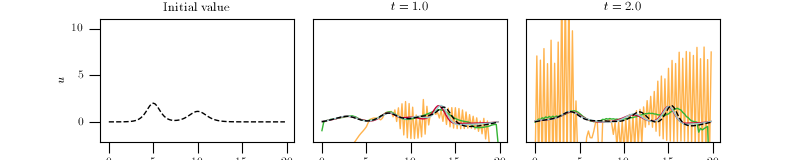

In [9]:
u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
for (u, _, _) in model_solutions_original:
    if u.max() > u_max:
        u_max = u.max()
    if u.min() < u_min:
        u_min = u.min()
u_min = max(u_min, -2)
u_max = min(u_max, 10)

N = t_sample.shape[0]-1
u0 = u_exact_orig[0, :]
fig = plt.figure(figsize=(8, 1.6))
ax1 = fig.add_subplot(1, 3, 1)
col = 2
ax1.set_title('Initial value')
ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1)
ax1.set_ylim([1.1*u_min, 1.1*u_max])
ax1.set_ylabel('$u$')
ax1.set_xlabel('$x$')
for i in range(1,3):
    ax1 = fig.add_subplot(1, 3, col)
    ax1.set_title(f'$t = {i/2*t_max}$')
    for j, (u, modeltype, _) in enumerate(model_solutions_original):
        ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
    ax1.plot(x, u_exact_orig[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
    ax1.set_xlabel('$x$')
    ax1.set_yticks([])
    ax1.set_ylim([1.1*u_min, 1.1*u_max])
    col += 1
ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
#fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
#fig.savefig('figs/paper/kdv_waves_time.pdf', bbox_inches='tight')

#### Removing the external force

In [10]:
PDE_system_no_force = phsys.KdVSystem(x=x, eta=eta, gamma=gamma, nu=nu, force=None, force_jac=None,
                                     init_sampler=phsys.initial_condition_kdv(x, eta))
u_exact_no_force, _, _, _ = PDE_system_no_force.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)

In [11]:
model_solutions_no_force = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='Baseline (1NN)' or modeltype=='Baseline (2NN)':
        def basemodel_no_force(u, t, x):
            return (model.rhs_model(u,t,x) - 
                    model.rhs_model(torch.zeros_like(u),t,x))
        u_dot = lambda t, u: basemodel_no_force(
                                 torch.tensor(u.reshape(1, u.shape[-1]), dtype=ttype),
                                 torch.tensor(np.array(t).reshape((1, 1)), dtype=ttype),
                                 torch.tensor(x.reshape(1, x.shape[-1]), dtype=ttype)
                                 ).detach().numpy().flatten()
        out_ivp = solve_ivp(fun=u_dot, t_span=(t_sample[0], t_sample[-1]),
                            y0=u0.flatten(), t_eval=t_sample, rtol=1e-10)
        u_model = out_ivp['y'].T
        model_solutions_no_force.append((u_model, modeltype, 'No force'))
    else:
        phmodel = phnn.ConservativeDissipativeNN(
                                                 PDE_system.nstates,
                                                 kernel_sizes=model.kernel_sizes[:3]+[0],
                                                 structure_matrix=model.S(),
                                                 dissipation_matrix=model.P(),
                                                 symmetric_matrix=model.D_flat(),
                                                 hamiltonian_true=model.hamiltonian,
                                                 grad_hamiltonian_true=model.dH,
                                                 dissintegral_true=model.dissintegral,
                                                 grad_dissintegral_true=model.dV
                                                )
        u_model, _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        model_solutions_no_force.append((u_model, modeltype, 'No force'))

<IPython.core.display.Javascript object>


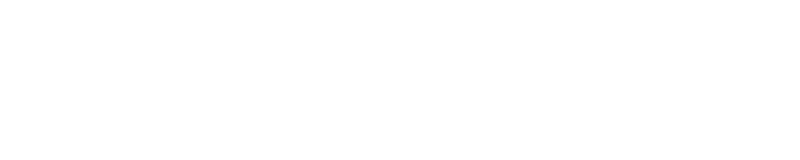

In [12]:
u_max, u_min = u_exact_no_force.max(), u_exact_no_force.min()
for (u, _, _) in model_solutions_no_force:
    if u is not None:
        if u.max() > u_max:
            u_max = u.max()
        if u.min() < u_min:
            u_min = u.min()
u_min = min(max(u_min, -2), -.15)
u_max = min(u_max, 6)

N = t_sample.shape[0]-1
u0 = u_exact_orig[0, :]
fig = plt.figure(figsize=(8, 1.6))
ax1 = fig.add_subplot(1, 3, 1)
col = 2
ax1.set_title('Initial value')
ax1.plot(x, u_exact_no_force[0,:], color='k', linestyle='--', linewidth=1)
ax1.set_ylim([1.1*u_min, 1.1*u_max])
ax1.set_ylabel('$u$')
ax1.set_xlabel('$x$')
for i in range(1,3):
    ax1 = fig.add_subplot(1, 3, col)
    ax1.set_title(f'$t = {i/2*t_max}$')
    for j, (u, modeltype, _) in enumerate(model_solutions_no_force):
        if u is not None:
            ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j+1], linewidth=1, label=modeltype) 
    ax1.plot(x, u_exact_no_force[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
    ax1.set_xlabel('$x$')
    ax1.set_yticks([])
    ax1.set_ylim([1.1*u_min, 1.1*u_max])
    col += 1
ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
#fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
#fig.savefig('figs/paper/kdv_waves_time.pdf', bbox_inches='tight')

#### Removing force and dissipation

In [13]:
PDE_system_no_visc = phsys.KdVSystem(x=x, eta=eta, gamma=gamma, nu=0., force=None, force_jac=None,
                                     init_sampler=phsys.initial_condition_kdv(x, eta))
u_exact_no_visc, _, _, _ = PDE_system_no_visc.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)

In [14]:
model_solutions_no_visc = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='PHNN (general)' or modeltype=='PHNN (informed)':
        phmodel = phnn.ConservativeDissipativeNN(
                                                 PDE_system.nstates,
                                                 kernel_sizes=model.kernel_sizes[:2]+[0,0],
                                                 structure_matrix=model.S(),
                                                 symmetric_matrix=model.D_flat(),
                                                 hamiltonian_true=model.hamiltonian,
                                                 grad_hamiltonian_true=model.dH,
                                                )
        u_model, _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        model_solutions_no_visc.append((u_model, modeltype, 'No force\ or visc.'))
    else:
        model_solutions_no_visc.append((None, None, None))

<IPython.core.display.Javascript object>


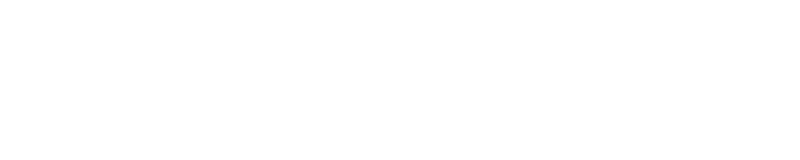

In [15]:
u_max, u_min = u_exact_no_visc.max(), u_exact_no_visc.min()
for (u, _, _) in model_solutions_no_visc:
    if u is not None:
        if u.max() > u_max:
            u_max = u.max()
        if u.min() < u_min:
            u_min = u.min()
u_min = min(max(u_min, -2), -.15)
u_max = min(u_max, 6)

N = t_sample.shape[0]-1
u0 = u_exact_orig[0, :]
fig = plt.figure(figsize=(8, 1.6))
ax1 = fig.add_subplot(1, 3, 1)
col = 2
ax1.set_title('Initial value')
ax1.plot(x, u_exact_no_visc[0,:], color='k', linestyle='--', linewidth=1)
ax1.set_ylim([1.1*u_min, 1.1*u_max])
ax1.set_ylabel('$u$')
ax1.set_xlabel('$x$')
for i in range(1,3):
    ax1 = fig.add_subplot(1, 3, col)
    ax1.set_title(f'$t = {i/2*t_max}$')
    for j, (u, modeltype, _) in enumerate(model_solutions_no_visc):
        if u is not None:
            ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j+1], linewidth=1, label=modeltype) 
    ax1.plot(x, u_exact_no_visc[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
    ax1.set_xlabel('$x$')
    ax1.set_yticks([])
    ax1.set_ylim([1.1*u_min, 1.1*u_max])
    col += 1
ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=3, fancybox=True)
#fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
#fig.savefig('figs/paper/kdv_waves_time.pdf', bbox_inches='tight')

#### Plotting all models

<IPython.core.display.Javascript object>


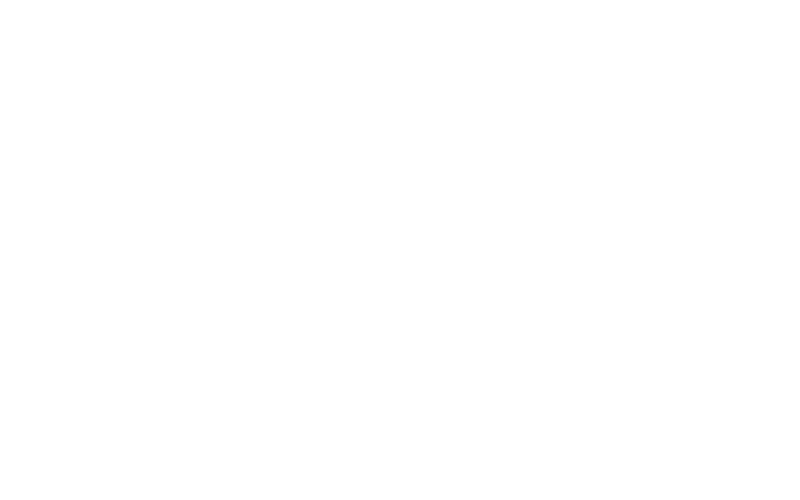

In [16]:
all_models = [model_solutions_original, model_solutions_no_force, model_solutions_no_visc]
all_exact = [u_exact_orig, u_exact_no_force, u_exact_no_visc]
model_names = ['Baseline (1NN)', 'Baseline (2NN)', 'PHNN (general)', 'PHNN (informed)']

col = 1

fig = plt.figure(figsize=(8, 5))

for m, model_solution in enumerate(all_models):
    
    u_exact = all_exact[m]
    model_solutions = all_models[m]
    u_max, u_min = u_exact.max(), u_exact.min()
    u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
    u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
    u_min = min(max(u_min, -2), -.15)
    u_max = min(u_max, 6)
    
    ax1 = fig.add_subplot(3, 3, 1+3*m)
    
    if m == 0:
        ax1.set_title('Initial value')
    if m != 2:
        ax1.set_xticks([])
    ax1.plot(x, u_exact_no_visc[0,:], color='k', linestyle='--', linewidth=1)
    ax1.set_ylim([1.1*u_min, 1.1*u_max])
    ax1.set_ylabel('$u$')
    if m == 2:
        ax1.set_xlabel('$x$')
        
    for i in range(1,3):
        ax1 = fig.add_subplot(3, 3, 1+i+3*m)
        if m == 0:
            ax1.set_title(f'$t = {i/2*t_max}$')
        if m != 2:
            ax1.set_xticks([])
        for j, (u, modeltype, _) in enumerate(model_solution):
            if u is not None:
                ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
        ax1.plot(x, u_exact[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
        if m == 2:
            ax1.set_xlabel('$x$')
        ax1.set_yticks([])
        ax1.set_ylim([1.1*u_min, 1.1*u_max])
    if m == 0:
        ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

#ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/paper/kdv_all.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


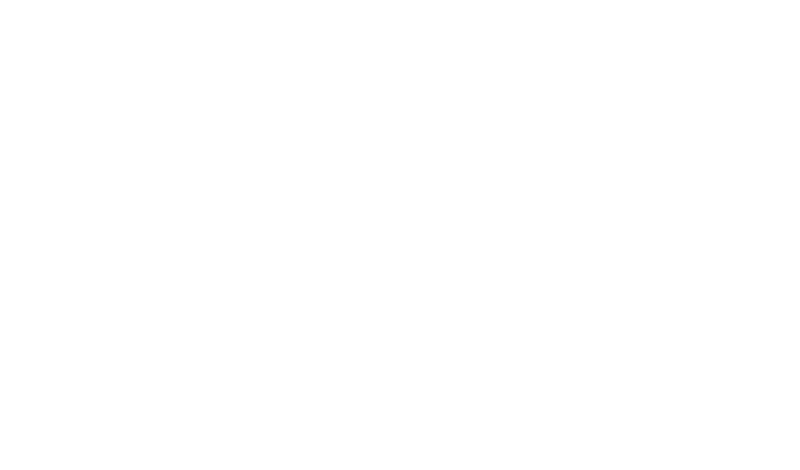

In [17]:
col = 1

fig = plt.figure(figsize=(8, 4.7))

for m, model_solution in enumerate(all_models):

    u_exact = all_exact[m]
    model_solutions = all_models[m]
#     u_max, u_min = u_exact.max(), u_exact.min()
#     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(max(u_min, -2), -.15)
#     u_max = min(u_max, 6)
    u_min = -.5
    u_max = 2.2
        
    for jp, (u, modeltype, _) in enumerate(model_solution):
        if jp < 2:
            j = jp + 2
        else:
            j = jp - 2
        if u is not None:
            ax1 = fig.add_subplot(3, 4, j+1+4*m)
            if m == 0:
                ax1.set_title(modeltype)
            ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
            ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
            if (m == 2) or (m == 1 and j > 1):
                ax1.set_xlabel('$x$')
            else:
                ax1.set_xticks([])
            if j == 0:
                ax1.set_ylabel(model_solution[-1][-1]+'\n$u$')
            else:
                ax1.set_yticks([])
            ax1.set_ylim([1.1*u_min, 1.1*u_max])
    #if m == 0:
    #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

#ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
fig.subplots_adjust(wspace=0.1)
#fig.savefig('figs/paper/kdv_spread.pdf', bbox_inches='tight')

#### Extracting the force term

In [19]:
model_forces = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='Baseline (1NN)':
        F_model = model.rhs_model(
                       torch.zeros_like(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype)),
                       torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                       torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                      ).detach().numpy().reshape(u_model.shape)
        model_forces.append((F_model, modeltype, 'Force'))
    elif modeltype=='Baseline (2NN)':
        u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        F_model = model.rhs_model.external_forces(
                       torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype),
                       torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                       torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                      ).detach().numpy().reshape(u_model.shape)
        correction = model.rhs_model.baseline_nn(
                       torch.zeros_like(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype)),
                       torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                       torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                      ).detach().numpy().reshape(u_model.shape)
        F_model_corrected = F_model + correction
        model_forces.append((F_model_corrected, modeltype, 'Force'))
    else:
        u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        F_model = model.external_forces(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype),
                                        torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                                        torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                                       ).detach().numpy().reshape(u_model.shape)
        if model.kernel_sizes[0] > 1:
            d = int((model.kernel_sizes[0]-1)/2)
            M = x.size
            D_flat = model.D_flat().detach().numpy()
            diagonals = np.concatenate([D_flat[0,:,(d+1):], D_flat[0], D_flat[0,:,:-(d+1)]], axis=1).T.repeat(M, axis=1)
            offsets = np.concatenate([np.arange(-M+1,-M+1+d),np.arange(-d,d+1),np.arange(M-d,M)])
            D = diags(diagonals, offsets, (M,M)).toarray()
            F_model = np.matmul(PDE_system.lhs_matrix, np.linalg.solve(D, F_model.T)).T
        model_forces.append((F_model, modeltype, 'Force'))
F_exact = PDE_system.external_forces(u_exact, t_sample).reshape(1,-1)

In [21]:
col = 1

fig = plt.figure(figsize=(8, 6))

for mp, model_solution in enumerate(all_models):
    if mp > 0:
        m = mp+1
    else:
        m = mp

    u_exact = all_exact[mp]
    model_solutions = all_models[mp]
#     u_max, u_min = u_exact.max(), u_exact.min()
#     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(max(u_min, -2), -.15)
#     u_max = min(u_max, 6)
    u_min = -.5
    u_max = 2.2
        
    for jp, (u, modeltype, _) in enumerate(model_solution):
        if jp < 2:
            j = jp + 2
        else:
            j = jp - 2
        if u is not None:
            ax1 = fig.add_subplot(4, 4, j+1+4*m)
            if m == 0:
                ax1.set_title(modeltype)
            ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
            ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
            if (m == 3) or (m == 2 and j > 1):
                ax1.set_xlabel('$x$')
            else:
                ax1.set_xticks([])
            if j == 0:
                ax1.set_ylabel(model_solution[-1][-1]+'\n$u$')
            else:
                ax1.set_yticks([])
            ax1.set_ylim([1.1*u_min, 1.1*u_max])
    #if m == 0:
    #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

m = 1
F_max, F_min = F_exact.max(), F_exact.min()
F_max = max(F.max() for (F, _, _) in model_forces if F is not None)
F_min = min(F.min() for (F, _, _) in model_forces if F is not None)
F_min = min(max(F_min, -2), -.15)
F_max = min(F_max, 6)
#F_min = -.5
#F_max = 2.2
for jp, (F, modeltype, _) in enumerate(model_forces):
    if jp < 2:
        j = jp + 2
    else:
        j = jp - 2
    if F is not None:
        ax1 = fig.add_subplot(4, 4, j+1+4*m)
        if m == 0:
            ax1.set_title(modeltype)
        ax1.plot(x, F[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
        ax1.plot(x, F_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
        ax1.set_xticks([])
        if j == 0:
            ax1.set_ylabel('$f$')
        else:
            ax1.set_yticks([])
        ax1.set_ylim([1.1*F_min, 1.1*F_max])


#ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/paper/kdv_spread.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>